# Efficient Sequence Modeling with String Kernels

<br/>
<div style="text-align: right"><font color="gray">Martin Stražar, 31 August 2018</font></div>

A large part of the time budget in a modern data analysis project is allocated to data preparation, in order to make it usable with off-the-shelf machine learning algorithms. In fields such as bioinformatics, text mining or speech recognition, we are often faced with data that are not straightforwardly represented in a vector space. Think chunks of text, sound recordings of different lengths and bitrates, or phylogenetic trees. 

<i>Kernels</i>, or covariance functions, provide a way to think in terms of similarities between data points, and, subject to certain technical conditions, correspond to inner products in vector spaces. 

Apart from interpretability, this is also important from a computational point of view, as we can often circumvent computing the vector space representations. Here, as we illustrate, efficient practical implementation plays a crucial role, as many sequence models only become useful with really large data sets (Ben-Hur et al., 2008). 

<figure style="float: right; margin-left: 20px; max-width: 300px;">
<img src="./img/chr-dna.png"> 
<figcaption align="center"><font color="gray">DNA encodes genes, which make up chromosomes. It stores all the hereditary and developmental information in an organism. </font></figcaption>
</figure>

In this tutorial post, we choose a common scenario in bioinformatics: modelling of nucleotide sequences. We introduce string kernels (Sonnenburg et al. 2006), a tool to map data represented as strings to real-valued vector spaces. The tutorial presents:
<ol>
    <li> A unified way to define multiple common string kernels,</li>
    <li> an efficient implementation with sparse matrices, and</li>
    <li> an example of sequence classification using machine learning. </li>
</ol>

## String kernels

The flag carrier of nucleotide sequences is DNA; it contains all the necessary hereditary as well as developmental information in an organism, encoded using just four symbols - nucleobases.  Consider the following hypothetical DNA sequences of equal length.

$$
\mathbf{s} = \text{ATTTAGCCACA} \\
\mathbf{t} = \text{TTTAGGCCGAT}
$$

<br/>
In what ways could $\mathbf{s}$ and $\mathbf{t}$ be deemed similar? Well, they appear to match in certain positions, some even consecutive. Note for example a matching length-3 substring:

$$
\mathbf{s} = \text{ATTTA}\textbf{GCC}\text{ACA} \\
\mathbf{t} = \text{TTTAG}\textbf{GCC}\text{GAT}.
$$

We can also find some matching if we are allowed to shift the strings by a small amount: 

$$
\mathbf{s} = \text{A}\textbf{TTTA}\text{GCCACA} \\
\mathbf{t} = \textbf{TTTA}\text{GGCCGAT}.
$$


<br/>
The above situation is common in biology, as cells constantly divide and make errors when copying DNA, also known as mutations. Nucleobases get shifted around, deleted or even replaced (more on this later). From a modelling perspective, let us design a <i>kernel</i> function on a pair of strings, that would count the number of matching, length-$k$ substrings ($k$-mers) that are allowed to be shifted by at most $\delta$.


### The substring kernel

The commonly-used <i>Substring kernel</i> captures the above notions. It is defined as:

$$ K_{k, \delta}(\mathbf{s}, \mathbf{t}) = \sum_{i=0}^{L-k+1} \sum_{d=-\delta}^{\delta} I(\mathbf{s}[i:i+k], \mathbf{t}[i+d:i+d+k]) $$ 

where the sum is defined for $i+d >= 0$ and $i+d+k <= L$ and $I$ is the indicator function, i.e. $I(\mathbf{u}, \mathbf{v}) = 1 \text{ if } \mathbf{u}=\mathbf{v} \text{ else } 0$. Here is it intuitive Pythonesque implementation using generators.

In [10]:
import itertools as it
def string_kernel(s, t, k=3, delta=0):
    """ Basic string kernel with displacement assuming equal lengths. """
    L = len(s)
    return sum(((s[i:i + k] == t[d + i:d + i + k])
                for i, d in it.product(range(L - k + 1), range(-delta, delta + 1))
                if i + d + k <= L and i + d >= 0))

The above function correctly quantifies the similarities between $\mathbf{s}$ and $\mathbf{t}$, depending on substring length $k$ and shift $\delta$. Note that increasing $\delta$ captures three additional substrings. 

In [11]:
s = "ATTTAGCCACA"
t = "TTTAGGCCGAT"
string_kernel(s, t, k=3, delta=0)

1

In [12]:
string_kernel(s, t, k=3, delta=1)

4

The trouble with this seemingly optimal implementation is its terrible inefficiency with large data sets. In typical machine learning applications, computing the <i>kernel matrix</i> amounts to computing the kernel function between all pairs of strings in a data set, an operation of quadratic complexity.


In [13]:
def kernel_matrix(S, kernel, **kwargs):
    """ Compute the kernel matrix between all pairs of strings in a list S"""
    N = len(S)
    K = np.zeros((N, N))
    for i in range(N):
        K[i, i] = kernel(S[i], S[i], **kwargs)
    for i, j in it.combinations(range(N), 2):
        K[i, j] = K[j, i] = kernel(S[i], S[j], **kwargs)
    return K

Let's also generate 1000 strings, as nature (evolution) would. Starting from an initial sequence, randomly replace one character at a single random position. This generates a list of sequences that are increasingly dissimilar to the initial sequence.

In [14]:
import numpy as np

# Generate random data
L = 10
N = 1000
dna = ["A", "C", "G", "T"]
starting = "".join(np.random.choice(["A", "C", "G", "T"], size=L, replace=True))
S = [starting]                                    
for i in range(1, N):
    j = np.random.choice(np.arange(L))
    r = S[i-1][:j] + str(np.random.choice(dna)) + S[i-1][j+1:]
    S.append(r)
print(S[:10])

['GGCACGCAAC', 'GGCACGCCAC', 'GGCACGCAAC', 'TGCACGCAAC', 'TGCTCGCAAC', 'TGCCCGCAAC', 'TGCCGGCAAC', 'TGCCGGCAGC', 'GGCCGGCAGC', 'GGCCTGCAGC']


Now for computing the kernel matrix.

In [15]:
from time import time
t0 = time()
K = kernel_matrix(S, string_kernel, k=3, delta=1)
t0 = time() - t0
print("String kernel (naive): %.3f s" % t0)

String kernel (naive): 6.294 s


This takes a few seconds (depending on hardware), which is a long time in computing. Here is how $\mathbf{K}$ looks like for first 100 sequences. Note that its largest values lie on and around the diagonal, reflecting the effect of our simulated evolution - sequences closest in time are more similar, although some sporadic similarities can appear on the way.

By computing the kernel matrix, we have (perhaps inadvertedly) computed a vector representation of our data. This particular vector space has 1000 dimensions. 

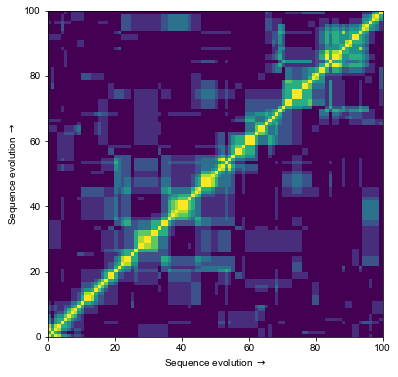

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
_ = plt.pcolor(K[:100, :100])
_ = plt.xlabel("Sequence evolution $\\rightarrow$")
_ = plt.ylabel("Sequence evolution $\\rightarrow$")

Before introducing a matrix implementation, we introduce an enhancement to the substring kernel that also captures nucleobase <i>substitutions</i>. 


### Substring kernel with mismatches


To allow for at most $m$ mismatches between the compared substrings, we define an auxiliary function, $\text{miss}(\mathbf{u}, \mathbf{v})$, that counts the number of positions in which the strings $\mathbf{u}, \mathbf{v}$ differ. The <i>Substring mismatch kernel</i> is then defined as:

$$ K_{k, \delta, m}(\mathbf{s}, \mathbf{t}) = \sum_{i=0}^{L-k+1} \sum_{d=-\delta}^{\delta} \text{int}\big( \text{miss}(\mathbf{s}[i:i+k], \mathbf{t}[i+d:i+d+k]) < m \big) $$ 

with the same constraints on the sum as the Substring kernel above. Note that this construction contains the <i>Substring kernel</i> for $m = 0$.

In [17]:
def miss(s, t):
    """ Count the number of mismatches between two strings."""
    return sum((si != sj for si, sj in zip(s, t)))

def string_kernel_mismatch(s, t, k=3, delta=1, m=1):
    """ String kernel with displacement and mismatches. """
    L = len(s)
    return sum(((miss(s[i:i + k], t[d + i:d + i + k]) <= m)
                for i, d in it.product(range(L - k + 1), range(-delta, delta + 1))
                if i + d + k <= L and i + d >= 0))

### Penalizing mismatches and shitfs

To further increase the model capacity, we can reward good substring matches, or equivalently, penalize bad matches. By introducing two additional parameters, $0 < \gamma_1, \gamma_2 <=1$,
we can get the kernel to decay exponentially with increasing shifts or number of mismatches.

$$ 
\begin{split}
K_{k, \delta, m,\gamma_1,\gamma_2}(\mathbf{s}, \mathbf{t}) = \sum_{i=0}^{L-k+1} \sum_{d=-\delta}^{\delta} &\text{exp}(-\gamma_1 d^2) \ \text{exp}(-\gamma_2\ \text{miss}(\mathbf{s}[i:i+k], \mathbf{t}[i+d:i+d+k])) \\
& \quad \text{if } \text{miss}(\mathbf{s}[i:i+k], \mathbf{t}[i+d:i+d+k]) < m \text{ else } 0.
\end{split}
$$ 

where the condition is checked for every term of the sum and the same constraints on $d$ apply. With appropriate settings of $\gamma_1, \gamma_2$, and $m$, we can again recover both of the above kernels.




In what follows, we assume $\gamma_1 = \gamma_2$ for simplicity. Assuming $\gamma_1 < 1$ also causes the function to always be positive-semidefinite. The proof of this is out of scope of this post, but it can be derived by following simple rules of combining kernels (Bishop, 2006).



In [18]:
def string_kernel_mismatch_exp(s, t, k=3, delta=1, m=1, gamma=0.99):
    """ String kernel with displacement, mismatches and exponential decay. """
    L = len(s)
    return sum(((np.exp(-gamma * d**2) \
                 * np.exp(-gamma * miss(s[i:i + k], t[d + i:d + i + k])) \
                 * (miss(s[i:i + k], t[d + i:d + i + k]) <= m) 
                for i, d in it.product(range(L - k + 1), range(-delta, delta + 1))
                if i + d + k <= L and i + d >= 0)))

The latest kernel smoothly interpolates between the first two kernels.

In [19]:
print(string_kernel(s, t, k=3, delta=1))
print(string_kernel_mismatch_exp(s, t, k=3, delta=1, m=1, gamma=0.99))
print(string_kernel_mismatch_exp(s, t, k=3, delta=1, m=1, gamma=0.66))
print(string_kernel_mismatch_exp(s, t, k=3, delta=1, m=1, gamma=0.33))
print(string_kernel_mismatch_exp(s, t, k=3, delta=1, m=1, gamma=1e-5))
print(string_kernel_mismatch(s, t, k=3, delta=1, m=1))

4
4.01524454909
5.41936524734
7.5830201375
10.9998700009
11


Notice how $\gamma$ allows us to set different levels of sensitivity of the kernel. The general evolution trajectory still seems to be retained. 

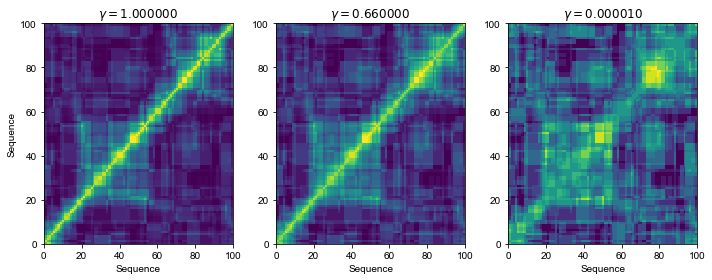

In [20]:
N = 100
gammas = [1, 0.66, 1e-5]
Ks = [kernel_matrix(S[:N], string_kernel_mismatch_exp, k=3, delta=1, m=1, gamma=g) for g in gammas]
fig, ax = plt.subplots(nrows=1, ncols=len(gammas), figsize=(10, 4))
ax[0].set_ylabel("Sequence")
for ki, K in enumerate(Ks):
    ax[ki].set_title("$\\gamma=%f$" % gammas[ki])
    ax[ki].pcolor(K)
    ax[ki].set_xlabel("Sequence")
fig.tight_layout()

<br/>
<br/>
## Efficient implementation with sparse matrices


Small shifts $\delta$ and the maximum mismatch cut-off in the definition of $K_{k, \delta, m,\gamma}$ guarantee that the kernel matrix is sparse for reasonable values of $k$ and $m$. Exploiting the efficient sparse matrix data structures in Python will enable a fast computation of the kernel matrix for large data sets. This is a classic example of exploiting the time-memory trade-off; in particular, pre-defining which substrings are allowed to match in form of a matrix. 

The description below is split in four parts and presents the key steps. The implementation that correctly exploits sparsity is somewhat involved and is included in a separate <a href="sklib.py">sklib.py</a>.


### Data representation

We represent the data a positional k-mer binary matrix; at each position $i$ in the sequence, we mark the corresponding k-mer starting at position $i$.


$$
\begin{align*}
\mathbf{X} = \left( 
\begin{array}{cccc}
\text{AAA}_0 & \text{AAC}_0 & \cdots & \text{TTT}_{L-k+1} \\
      1 &  0 & \cdots & 0 \\
      \vdots &  \cdots & \ddots & \vdots \\
      0 & 1 & \cdots & 1
    \end{array} 
\right)
\end{align*}
$$

Assuming an alphabet of 4 letters, the density (proportion of non-zero values) of the data matrix is proportional to $\frac{1}{4^k}$, and thus independent of length $L$.

When sequences represented as vectors, the sum defining $K_{k, \delta, m,\gamma}$ corresponds to a <a href="https://en.wikipedia.org/wiki/Quadratic_form">quadratic form</a>. All we have to do is construct the matrix of coefficients. The sum is logically decomposed in two parts, the <i>distance kernel</i> and the <i>mismatch kernel</i>.

In [21]:
from sklib import kmer_sparse_matrix

### Distance kernel

The distance (shift) kernel is parametrized by $\delta$ and $\gamma$. It quantifies the effect of shifts in matching k-mers. For each shift $d = j - i$, with $i, j \in 1,2,...,L-k+1$ the matrix is defined as:

$$
\mathbf{K}_\delta[i, j] = 
\begin{cases}
    \text{exp}(-\gamma d^2), & \text{if } d \geq \delta, \\
    0,              & \text{otherwise.}
\end{cases}
$$

The density of this matrix is proportional to $\frac{\delta}{L-k+1}$. Typically, we would have $\delta << L-k+1$.

In [22]:
from sklib import distance_matrix

### Mismatch kernel

The remaining part is to define a kernel matrix between all k-mers, penalizing mismatches according to $\gamma$. Let $\mathbf{u}, \mathbf{v}$ be two k-mers.

$$
\mathbf{K}_m[\mathbf{u}, \mathbf{v}] = 
\begin{cases}
    \text{exp}(-\gamma \ \text{miss}(\mathbf{u}, \mathbf{v})), & \text{if } \text{miss}(\mathbf{u}, \mathbf{v}) \geq m \\
    0,              & \text{otherwise}
\end{cases}
$$


The density of this matrix is proportional to $\sum_{j=0}^{m} 4^j {k \choose j}/4^k$. The number of allowed mismatches $m$ must therefore be small relative to $k$ for reasonably sparse matrices.

In [23]:
from sklib import mismatch_matrix

### Combining kernels over multiple dimensions

All that remains is to combine the distance and the mismatch kernels into a single matrix that defines the coefficients (C) of the quadratic form $K_{k, \delta, m,\gamma}$. Here, we use the <a href="https://en.wikipedia.org/wiki/Kronecker_product">Kronecker product</a>. This is an asymmetric operation that tiles the matrices of sizes $a \times a$ and $b \times b$ into a matrix of size $ab \times ab$:

$$
\begin{align*}
\mathbf{C}_{\delta m} = \mathbf{K}_\delta \otimes \mathbf{K}_m = \left( 
\begin{array}{cccc}
      \mathbf{K}_\delta[0, 0] \ \mathbf{K}_m &  \mathbf{K}_\delta[0, 1] \ \mathbf{K}_m  & \cdots & \mathbf{K}_\delta[0, M] \ \mathbf{K}_m  \\
      \vdots &  \cdots & \ddots & \vdots \\
      \mathbf{K}_\delta[M, 0] \ \mathbf{K}_m & \mathbf{K}_\delta[M, 1] \ \mathbf{K}_m & \cdots & \mathbf{K}_\delta[M,M] \ \mathbf{K}_m
      \end{array} 
\right)
\end{align*}
$$

with $M=L-k+1$. 



In [24]:
import scipy.sparse as sp
def coefficients(L, k, m=0, delta=1, gamma=1, base=4):
    """
    Coefficents to generate an arbitray string kernel.
    :param L: Sequence length.
    :param k: K-mer length.
    :param m: Allowed number of mismatches.
    :param delta: Maximum shift (offset).
    :param gamma: Bandwidth (penalty) parameter.
    :param base: Alphabet size.
    :return:
    """
    M = mismatch_matrix(k=k, m=m, gamma=gamma, base=base)
    D = distance_matrix(L=L, k=k, delta=delta, gamma=gamma)
    return sp.kron(D, M, format="csr")

Assuming all of the matrices are sparse, in line with the reasoning above, the coefficient matrix $\mathbf{C}_{\delta m}$ is sparse as well. Moreover, the coefficient matrices can be efficiently cached for different parameters settings, as they are data-independent.
Both the dot product and the Kronecker product have efficient implementations for sparse input matrices. Finally, we exploit sparsity to efficiently compute kernel matrices over large data sets.


$$ \mathbf{K}_{\delta m}(\mathbf{X}, \mathbf{X}) = \mathbf{X}\mathbf{C}_{\delta m}\mathbf{X}^T $$

In [30]:
# Caching of coefficients
_coef_cache = dict()

def string_kernel_matrix(X1, X2, **kwargs):
    """
    :param X1: Strings represented as a sparse k-mer matrix.
    :param X2: Strings represented as a sparse k-mer matrix.
    :param kwargs: Arguments to the kernel.
    :return:
    """
    global _coef_cache
    mode = frozenset(kwargs.items())
    ky = hash(mode)
    if ky not in _coef_cache:
        C = _coef_cache[ky] = coefficients(**kwargs)
    else:
        C = _coef_cache[ky]
    return X1.dot(C).dot(X2.T)

## Comparison of run times

Let's compare run times for variable $k$ and the number of sequences, but also make sure the matrix implementation actually matches the ad-hoc implementation. 

In [60]:
Ns = [10, 30, 100, 300, 1000]
ks = [2, 3, 5]

T = {"adhoc": np.zeros((len(Ns), len(ks))),
     "adhoc-exp": np.zeros((len(Ns), len(ks))),
     "matrix": np.zeros((len(Ns), len(ks)))}
         
for ki, k in enumerate(ks):
    for ni, n in enumerate(Ns):
        t0 = time()
        K0 = kernel_matrix(S[:n], string_kernel, k=k, delta=1) # no mismatches allowed
        t0 = time() - t0;
        T["adhoc"][ni, ki] = t0
        
        t0 = time()
        K0 = kernel_matrix(S[:n], string_kernel_mismatch_exp, k=k, delta=1, m=1, gamma=1)
        t0 = time() - t0;
        T["adhoc-exp"][ni, ki] = t0
        
        t1 = time() # Includes time to construct a sparse matrix
        Sx, _ = kmer_sparse_matrix(S, k=k, mode="positional") 
        K1 = string_kernel_matrix(Sx[:n], Sx[:n], L=L, k=k, delta=1, m=1, gamma=1)
        t1 = time() - t1;
        T["matrix"][ni, ki] = t1
         
        diff = np.linalg.norm(K0-K1.toarray())
        print("n: %d\tk: %d\tt0: %.2f (s)\tt1: %.3f (s)\t|K0-K1|: %.2e" % (n, k, t0, t1, diff))

n: 10	k: 2	t0: 0.02 (s)	t1: 0.172 (s)	|K0-K1|: 1.40e-14
n: 30	k: 2	t0: 0.10 (s)	t1: 0.091 (s)	|K0-K1|: 2.48e-14
n: 100	k: 2	t0: 1.12 (s)	t1: 0.135 (s)	|K0-K1|: 6.68e-14
n: 300	k: 2	t0: 10.14 (s)	t1: 0.090 (s)	|K0-K1|: 1.70e-13
n: 1000	k: 2	t0: 110.98 (s)	t1: 0.115 (s)	|K0-K1|: 5.02e-13
n: 10	k: 3	t0: 0.01 (s)	t1: 0.096 (s)	|K0-K1|: 7.96e-15
n: 30	k: 3	t0: 0.09 (s)	t1: 0.093 (s)	|K0-K1|: 1.23e-14
n: 100	k: 3	t0: 1.03 (s)	t1: 0.094 (s)	|K0-K1|: 3.70e-14
n: 300	k: 3	t0: 9.20 (s)	t1: 0.094 (s)	|K0-K1|: 7.71e-14
n: 1000	k: 3	t0: 100.51 (s)	t1: 0.103 (s)	|K0-K1|: 1.61e-13
n: 10	k: 5	t0: 0.01 (s)	t1: 0.206 (s)	|K0-K1|: 1.26e-15
n: 30	k: 5	t0: 0.07 (s)	t1: 0.106 (s)	|K0-K1|: 2.18e-15
n: 100	k: 5	t0: 0.78 (s)	t1: 0.086 (s)	|K0-K1|: 6.02e-15
n: 300	k: 5	t0: 6.83 (s)	t1: 0.090 (s)	|K0-K1|: 1.11e-14
n: 1000	k: 5	t0: 78.54 (s)	t1: 0.094 (s)	|K0-K1|: 2.42e-14


The matrix implementation, expectedly, performs orders of magnitude faster than computing the kernels in an ad-hoc manner. It stays well below one second for 1000 sequences, whereas the ad-hoc implementation takes more than a minute.

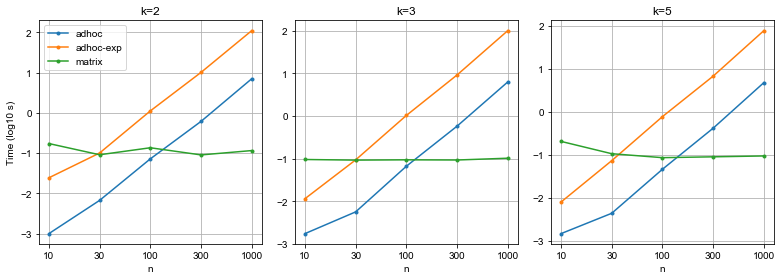

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=len(ks), figsize=(11, 4))
for ki, k in enumerate(ks):
    ax[ki].set_title("k=%d" % k)
    ax[ki].set_xlabel("n")
    ax[ki].set_xticks(range(len(Ns)))
    ax[ki].set_xticklabels(Ns)
    for label, times in T.items():
        ax[ki].plot(np.log10(times[:, ki]), ".-", label=label)
    ax[ki].grid()
ax[0].set_ylabel("Time (log10 s)")
ax[0].legend()
fig.tight_layout()


## Simple example of sequence classification with kernels

<figure style="float: right; margin-left: 20px; max-width: 300px;">
<img src="./img/rna-protein-0.png"> 
<figcaption align="center"><font color="gray">An RNA-binding protein (RBP) recognizes specific sites on the RNA, characterized by short sequence patterns (motifs). </font></figcaption>
</figure>

The data is related to the TDP-43 RNA binding protein (Tollervey et al., 2011). In short, the data contains the sequences that interact with this protein (positives, $y=1$), and those that don't (negatives, $y=-1$). This is a typical machine learning task of binary classification. 

The data can be downloaded <a href="./data-TDP43
.zip">here</a>. First, we load 1000 example DNA sequences and the corersponding target values (classfication as negative/positives).  Because the sequences are of varying length, they have been padded either side with an 'unknown' symbol, taken to be N. This data is provided with the GraphProt sequence prediction method (Maticzka et al., 2014).

In [59]:
Sp = np.load("data/ICLIP_TDP43.ls.seq.npy").astype(str)   # 1000 stored sequences
y = np.load("data/ICLIP_TDP43.ls.target.npy")             # Target values in {-1, 1}, 500 each
n_tr = 500                                                # Number of training sequences
print(Sp[:5])
print(y[:5])

[ 'NNNNNNNNNNNNNNCCCTGGCCTTCCCACAGTGTAATTATTGGGCTTATTTGGGGGATCATTTGCCTGATGTCGCTGTCAGTCCGGGAATGCCCTGAGGGTGGGGCCCCAGCAGCACTTAACTGCTTAGGGAATAGATGTGAAATGAACGCATGAATGAATAAAUGGAGUUGCUUUUGCUUGAACAAUAGAAAUUUAAUUCUCGCAGUCCTGGATGTGGAAATCTGAGACGAGGGTGGTAGCATGGTTCGGGGTCTCAGGGGGGGCTCTCTCCTTGGCTTGCAGATGGCCACCCTCTCGCTGTGTCCTCACATGGCAGGGAAAGCAGGACATATTTAACTAAGTACAAGTATGAAAATTANNNNNNNNNNNNNNN'
 'NNNNNNNNNNNNNNNATTTGGGCATATTTTCTTCTTCCTTCTAAGCCTACATCAGTATTTACTTCTTTCATATATTCTTCCTAACTTATGTGGCCCCATATTGATCGTCTTACATTGATTGTCCTTGGAACCCTCATAAAATCCCATGTCATGCTGTGATCCATTTTGCTTGTAAGTTGTGTCATTATTGTCTGTCAATTAATTTACTTTGTCCACGAGGTGAGTATAGCATCTGGACCTTCCATTTATTTCTAATGACCGTGATAGTCTAATGCAATATGGCTCAGGCTGTTAATTCAGAATAAATGCTTGTTAATTTACTGATACACTGCCATATCTGTATATTTTTGCAACTCTATANNNNNNNNNNNNNNN'
 'NNAGGCTGTTGATCTCTGAGCTTCTGTTTCTACCTGCTTAAAATGACGGTTACTGCACAGGGCTGTGTGAGGGTTACAGTGCGTCTCTGGGCTGCTCCCAGCCATGGCAGGCCCCTGGGAATCAAGGTCATCAGCTGCTTGTCCAAGGCAGCAGTTAGTGGTTGTGAATGGTGCGTGTGAGATCTGCATCCTGGCGTCAGGCCTCCTTCCTGCCTTACCCAGGACAGCCCAGTTGCAGC

### Classification performance

Our sample experiment will use binary classification models from the <a href="http://scikit-learn.org">Scikit-learn library</a>.


In [28]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics.classification import accuracy_score

We will begin be evaluating if the sequences contain any pattern that could separate them into positives and negatives. The feasibility of this process will be measured by how accurately a machine learning model, trained on <i>training</i> sequences can classify <i>unseen</i> (test) sequences. To get confidence estimates, the random split between training and test sequences is repeated many times.

In [57]:
# Model parameters ; we will let gamma vary
np.random.seed(42)
delta = 3
k = 4
m = 1
gammas = [0, 1e-5, 1e-4, 1e-3, 0.11, 0.33, 0.66]
c = 0.003 # Regularization strength

# Kernel is computed according to the parameters
Sx, cols = kmer_sparse_matrix(Sp, k=k, mode="positional")

# Evalaution parameters
repeats = 10  
n_tr = 800    # number of training sequences
scores = np.zeros((repeats, len(gammas)))
inxs = np.arange(len(S))

# Run cross-validation
for gi, g in enumerate(gammas):
    Kx = string_kernel_matrix(Sx, Sx, L=len(Sp[0]), k=k, m=m, delta=delta, gamma=g)
    print("\nGamma: %f" % g)
    print("---------")
    for itr in range(repeats):
        # Randomly shuffle data and split
        np.random.shuffle(inxs)
        tr, te = inxs[:n_tr], inxs[n_tr:]
        
        # Fit a classification model and score its accuracy on unseen data
        model = LogisticRegression(penalty="l1", C=c)
        model.fit(Kx[tr, :][:, tr], y[tr])
        yp_tr = model.predict(Kx[tr, :][:, tr])
        acc_tr = accuracy_score(y_true=y[tr], y_pred=yp_tr)
    
        yp = model.predict(Kx[te, :][:, tr])
        acc_te = accuracy_score(y_true=y[te], y_pred=yp)
        scores[itr, gi] = acc_te
        print("Iteration: %d\taccuracy (train): %.2f\taccuracy (test):%.2f" 
              % (itr, acc_tr, acc_te))


Gamma: 0.000000
---------
Iteration: 0	accuracy (train): 0.85	accuracy (test):0.74
Iteration: 1	accuracy (train): 0.84	accuracy (test):0.73
Iteration: 2	accuracy (train): 0.85	accuracy (test):0.72
Iteration: 3	accuracy (train): 0.86	accuracy (test):0.71
Iteration: 4	accuracy (train): 0.86	accuracy (test):0.74
Iteration: 5	accuracy (train): 0.85	accuracy (test):0.71
Iteration: 6	accuracy (train): 0.85	accuracy (test):0.74
Iteration: 7	accuracy (train): 0.84	accuracy (test):0.74
Iteration: 8	accuracy (train): 0.82	accuracy (test):0.80
Iteration: 9	accuracy (train): 0.84	accuracy (test):0.73

Gamma: 0.000010
---------
Iteration: 0	accuracy (train): 0.85	accuracy (test):0.78
Iteration: 1	accuracy (train): 0.85	accuracy (test):0.71
Iteration: 2	accuracy (train): 0.85	accuracy (test):0.74
Iteration: 3	accuracy (train): 0.85	accuracy (test):0.75
Iteration: 4	accuracy (train): 0.85	accuracy (test):0.72
Iteration: 5	accuracy (train): 0.84	accuracy (test):0.78
Iteration: 6	accuracy (train): 0.8

The scores are averaged over random splits of the data set. The dependence on $\gamma$ is displayed on the plot.

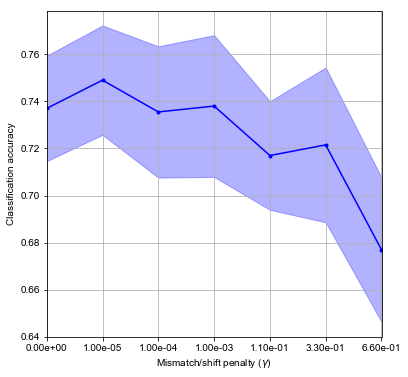

In [58]:
s_mean = scores.mean(axis=0)
s_std = scores.std(axis=0)
ticks = range(len(s_mean))
plt.figure(figsize=(6,6))
plt.plot(s_mean, ".-", color="blue")
plt.fill_between(ticks, s_mean+s_std, s_mean-s_std, color="blue", alpha=0.3)
plt.xticks(ticks)
plt.gca().set_xticklabels(["%.2e" % g for g in gammas])
plt.grid()
plt.xlim(0, len(ticks)-1)
plt.ylabel("Classification accuracy")
plt.xlabel("Mismatch/shift penalty ($\\gamma$)")
plt.show()

In this quick experiment, we can achieve about 75% of correct classification of sequences, which is not bad for a first try. Since the data set is balanced - positives and negatives are present in the same number - this result indicates that classifier performs better than a random assignment of labels.  

Also, setting $\gamma$ clearly has an effect and can boost performance for a few percent.

### Discovering patterns

The Logistic regression model is a linear classification model, in that it assumes the mean of the response to be a linear combination of input vectors. In other words, parts of the input vectors are more important than others and can provide insight into what drives the classification decision.

Let's train the model on the whole data set, taking into account a value of $\gamma$ selected in accordance with our first experiment.


In [50]:
Kx = string_kernel_matrix(Sx, Sx, L=len(Sp[0]), k=k, m=m, delta=delta, gamma=1e-5)
model = LogisticRegression(penalty="l1", )
model.fit(Kx, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The model is encoded as real-valued coefficients $\mathbf{\alpha} \in \mathbb{R}^N$, that combined with the data vectors (here, the kernel matrix) generate predictions $f(\mathbf{x})$ for a given sequence $\mathbf{x}$ (represented as a k-mer vector):

$$ \mathbf{f}(\mathbf{x})  = \text{logit}(\mathbf{K}(\mathbf{x}, \mathbf{X}) \mathbf{\alpha}), \quad  \mathbf{f}: \mathbb{R}^{L-k+1} \mapsto (0, 1).$$


The weights $\mathbf{\alpha}$ can be mapped back to the original space encoded by $\mathbf{X}$ as follows. 

$$ \mathbf{\beta} = \mathbf{\alpha}^T \mathbf{X}, \quad \mathbf{\beta} \in \mathbb{R}^{L-k+1}$$

This gives us an estimate of the importance of different k-mers at different positions in the sequence.

In [51]:
weights_seqs = model.coef_.ravel()
weights_feats = Sx.T.dot(weights_seqs)
top_feats = np.argsort(weights_feats).astype(int)[::-1][:10]
print([cols[r] for r in top_feats])

['TGTG_20', 'TGTG_18', 'GTGT_19', 'TGTG_158', 'GTGT_159', 'TGTG_37', 'TTTC_290', 'CTTT_281', 'TGTG_227', 'TTCA_271']


Among the top 10 important 4-mers, we discover TG-repeats, which is not a coincidence, since this is the well-known signature motif that the TDP-43 protein recognizes.

Finally, we can visualize the probability of top 5 4-mers accross all positive sequences. We sucessfully discover a peak of TGTG motifs around location 150 nucleotides within the sequences.

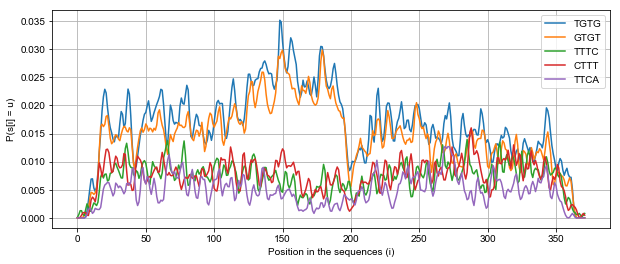

In [52]:
from scipy.stats import multivariate_normal as mvn
g = mvn.pdf([-2, -1, 0, 1, 2])

top_kmers = set([cols[r].split("_")[0] for r in top_feats])
plt.figure(figsize=(10, 4))
for kmer in top_kmers:
    col_indices = [i for i, col in enumerate(cols)if kmer in col]
    w = np.array(Sx[:500,col_indices].mean(axis=0)).ravel()    
    w = np.convolve(w, g, mode="same")  # Gaussian smoothing
    plt.plot(w,"-", label=kmer )
    
plt.grid()
plt.legend()
plt.xlabel("Position in the sequences (i)")
plt.ylabel("P(s[i] = u)")
plt.show()

## Conclusion

String kernels are a useful tool to apply maching learning to various sequence data sets. We showed how their efficient implementation allows us to apply string kernels to orders of magnitude larger data sets, which is crucial to find reliable patterns in sequence data.


#### References

Ben-Hur, A. et al. (2008) <i>Support vector machines and kernels for computational biology</i>, PLoS Computational Biology, 4(10). doi: 10.1371/journal.pcbi.1000173.

Sonnenburg, S., Rätsch, G. and Schölkopf, B. (2005) <i>Large scale genomic sequence SVM classifiers</i>, in Proceedings of the 22nd international conference on Machine learning, pp. 848–855.

Tollervey, J. R. et al. (2011) <i>Characterizing the RNA targets and position-dependent splicing regulation by TDP-43</i>, Nature Neuroscience, 14(4), pp. 452-U180. doi: 10.1038/nn.2778.

Maticzka, D. et al. (2014) <i>GraphProt: modeling binding preferences of RNA-binding proteins</i>, Genome Biology, 15(1), p. R17. doi: 10.1186/gb-2014-15-1-r17.

Bishop, C. M. (2006) <i>Pattern Recognition and Machine Learning</i>. Springer (Information Science and Statistics).